In [1]:
# train_anemia_xgb.py
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
csv_path = "ol_removed.csv"  # change if your file is elsewhere

In [3]:
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at path: {csv_path}")

In [5]:
df = pd.read_csv(csv_path).drop(columns=["Unnamed: 0"],axis=1)

# Basic checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values per column:\n", df.isnull().sum())

Shape: (10505, 6)
Columns: ['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV', 'Result']
Missing values per column:
 Gender        0
Hemoglobin    0
MCH           0
MCHC          0
MCV           0
Result        0
dtype: int64


In [6]:
# --- Preprocessing ---
# 1) Drop fully empty rows (if any)
df = df.dropna(how='all').reset_index(drop=True)

# 2) If there are non-numeric columns that shouldn't be, attempt conversion
for col in df.columns:
    if df[col].dtype == object:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 3) Fill numeric missing with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if df[c].isnull().any():
        df[c].fillna(df[c].median(), inplace=True)

In [7]:
# 4) Remove exact duplicates
before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
print(f"Removed {before - len(df)} duplicate rows.")

# 5) Ensure target column name (assumes 'Result' exists). Adjust if different.
target_col = "Result"
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Columns: {df.columns.tolist()}")

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

print("Class distribution:\n", y.value_counts())

Removed 1037 duplicate rows.
Class distribution:
 Result
0    6078
1    3390
Name: count, dtype: int64


In [8]:
# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [9]:
apply_smote = False
try:
    from imblearn.over_sampling import SMOTE
    minor_ratio = y_train.value_counts(normalize=True).min()
    if minor_ratio < 0.40 and len(y_train) >= 10:
        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
        apply_smote = True
        print("Applied SMOTE. New training distribution:", np.bincount(y_train_res)/len(y_train_res))
    else:
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
except Exception as e:
    print("imblearn not available or failed; proceeding without SMOTE:", e)
    X_train_res, y_train_res = X_train.copy(), y_train.copy()

Applied SMOTE. New training distribution: [0.5 0.5]


In [10]:
# --- Model + hyperparameter search ---
use_xgb = True
try:
    from xgboost import XGBClassifier
    base_clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
except Exception:
    use_xgb = False
    from sklearn.ensemble import RandomForestClassifier
    base_clf = RandomForestClassifier(random_state=42)
    print("XGBoost not available; falling back to RandomForest.")

# Pipeline with scaling (helps some datasets)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", base_clf)
])

In [11]:
# Param distributions (for RandomizedSearchCV)
if use_xgb:
    param_dist = {
        "clf__n_estimators": [50, 100, 150, 200, 300],
        "clf__max_depth": [2, 3, 4, 5, 6, 8],
        "clf__learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
        "clf__subsample": [0.6, 0.8, 1.0],
        "clf__colsample_bytree": [0.5, 0.7, 1.0],
        "clf__gamma": [0, 0.1, 0.3, 1]
    }
else:
    param_dist = {
        "clf__n_estimators": [50, 100, 200, 300],
        "clf__max_depth": [None, 4, 6, 8],
        "clf__min_samples_leaf": [1, 2, 4]
    }

In [12]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rnd = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=30, cv=cv,
                         scoring="accuracy", n_jobs=-1, random_state=42, verbose=1)

rnd.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'clf__colsample_bytree': [0.5, 0.7, ...], 'clf__gamma': [0, 0.1, ...], 'clf__learning_rate': [0.01, 0.03, ...], 'clf__max_depth': [2, 3, ...], ...}"
,n_iter,30
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [13]:
best = rnd.best_estimator_
print("Best params:", rnd.best_params_)

Best params: {'clf__subsample': 1.0, 'clf__n_estimators': 150, 'clf__max_depth': 4, 'clf__learning_rate': 0.1, 'clf__gamma': 0.1, 'clf__colsample_bytree': 0.7}


In [20]:
# Evaluate

y_pred = best.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("Classification report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 0.9884
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1216
           1       0.98      0.99      0.98       678

    accuracy                           0.99      1894
   macro avg       0.99      0.99      0.99      1894
weighted avg       0.99      0.99      0.99      1894

Confusion matrix:
 [[1201   15]
 [   7  671]]


In [15]:
X_test.head()

,Gender,Hemoglobin,MCH,MCHC,MCV
4815,0,13.700000,29.200000,34.900000,83.600000
8346,0,16.300000,31.000000,33.500000,92.300000
232,0,12.414049,26.536651,32.422746,98.153516
5175,0,15.400000,30.100000,33.400000,90.100000
1150,1,14.400000,29.800000,31.600000,92.400000


Feature importances:
 f4    511.0
f3    457.0
f2    363.0
f1    345.0
f0    108.0
dtype: float64


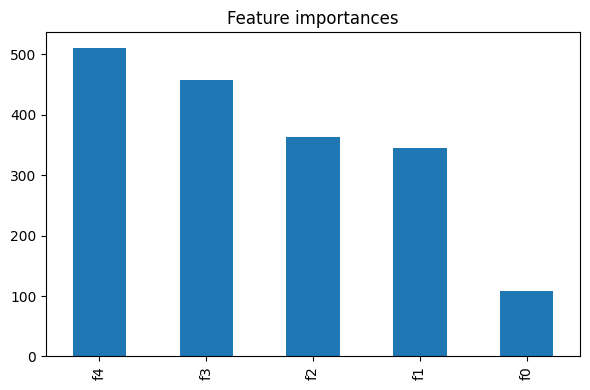

Saved trained model to best_anemia_model.pkl


In [19]:
# Feature importance (if available)
try:
    if use_xgb:
        booster = best.named_steps['clf'].get_booster()
        fmap = booster.get_score(importance_type='weight')
        # map names to scores
        fi_series = pd.Series(fmap).sort_values(ascending=False)
    else:
        fi = best.named_steps['clf'].feature_importances_
        fi_series = pd.Series(fi, index=X.columns).sort_values(ascending=False)
    print("Feature importances:\n", fi_series)
    # plot
    plt.figure(figsize=(6,4))
    fi_series.plot(kind='bar')
    plt.title("Feature importances")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not compute feature importances:", e)

# Save model
out_path = "best_anemia_model.pkl"
with open(out_path, "wb") as f:
    pickle.dump(best, f)
print(f"Saved trained model to {out_path}")

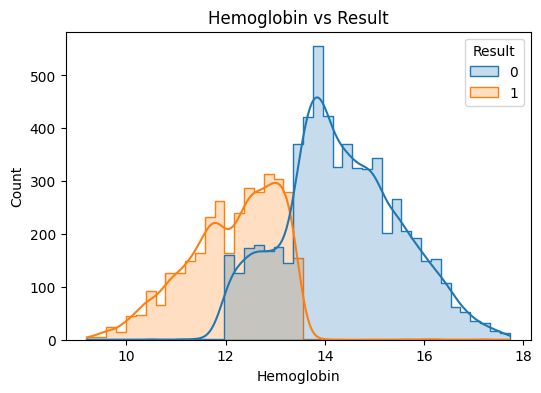

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.histplot(data=df, x="Hemoglobin", hue="Result", kde=True, element="step")
plt.title("Hemoglobin vs Result")
plt.show()


In [17]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best.named_steps['clf'], X, y, cv=5, scoring="accuracy")
print("Cross-validated accuracy:", scores, "Mean:", scores.mean())


Cross-validated accuracy: [0.92397043 0.99841605 0.99841605 0.99894348 0.99841521] Mean: 0.9836322448458195


In [16]:
X_test.head()

,Gender,Hemoglobin,MCH,MCHC,MCV
4815,0,13.700000,29.200000,34.900000,83.600000
8346,0,16.300000,31.000000,33.500000,92.300000
232,0,12.414049,26.536651,32.422746,98.153516
5175,0,15.400000,30.100000,33.400000,90.100000
1150,1,14.400000,29.800000,31.600000,92.400000


In [21]:
best.predict([[1,11.62877519536138,23.540191283355497,31.40299725827341,74.4269791005916]])

array([1])

In [22]:
best.predict([[1,16.531621056242642,25.06698174906588,33.07368159895778,95.41417031957054]])

array([0])

In [23]:
best.predict([[0,9,21.5,29.6,71.2]])

array([1])

In [24]:
best.predict([[0,15.4,16.9,28,94.9]])

array([0])

In [25]:
dtest=pd.read_csv("test1.csv").drop(columns=["Result"],axis=1)
testy=pd.read_csv("test1.csv")["Result"]
yp=best.predict(dtest)
from sklearn.metrics import accuracy_score
print(accuracy_score(testy,yp))

0.9570724841660803


In [26]:
import pickle

# Let's say your trained model is in a variable called `best`
# Choose a file name (e.g., "my_anemia_model.pkl")
model_filename = "my_anemia_model.pkl"

with open(model_filename, "wb") as f:
    pickle.dump(best, f)

print(f"✅ Model saved to {model_filename}")


✅ Model saved to my_anemia_model.pkl
